In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sympy
import matplotlib
%matplotlib inline

確率密度分布の推移を求める
状態名と遷移過程と半減期をインプット
分解しかしないパターンを実装した
数密度に左右されるような過渡状態を持つ場合、別のコードが必要

In [2]:
state_numbers = {
    "A": 0, #   状態名:通し番号
    "B": 1,
    "C": 2,
    "D": 3,
}

states_graph = [
    ("A", "B", float("inf"), 1, True),# 遷移前の状態, 遷移後の状態, 遷移前の状態の寿命, 数密度何倍になるか,　遷移先の状態は光励起直後か
    ("B", "C", 5, 1, False),
    ("C", "A", 25, 1, False),
]

bins = 10**4
before_lay_time_range = 10
after_lay_time_range = 90
lay_width_time_range = 2.5
time_range = before_lay_time_range + after_lay_time_range

In [3]:
lay_d = np.exp(-(np.arange(bins) - bins*0.1)**2/(bins*lay_width_time_range/time_range)**2)
lay_d /= np.sum(lay_d)

tl = [0.0]*len(state_numbers)
dp = [[0.0]*bins for _ in range(len(state_numbers))]

dp_index_graph = [[] for _ in range(len(state_numbers))]
lay_TFs = [False]*len(state_numbers)
for s1, s2, T, amp, lay_TF in states_graph:
    dp_index_graph[state_numbers[s1]].append((state_numbers[s2], T, amp))
    lay_TFs[state_numbers[s2]] = lay_TF
    if lay_TF:
        tl[state_numbers[s1]] = 1.0 # 初期密度が0ではない場合の値の代入。本当は、光への感度に比例した値を入れる必要がある


for t in range(bins):
    for i in range(len(dp_index_graph)):#   遷移元ループ
        for j, T, amp in dp_index_graph[i]:#    遷移先ループ
            if lay_TFs[j]:  #   指定された遷移先が光励起直後だった場合(指定された遷移元が入射前の定常状態だった場合)
                tl[i] -= lay_d[t]
                tl[j] += amp*lay_d[t]
            else:
                delta = tl[i] * (1.0 - np.exp(-(time_range/bins)/T))
                tl[i] -= delta
                tl[j] += amp*delta

            dp[i][t] = tl[i]
            dp[j][t] = tl[j]

0.0022567583513024977 0.9999999999999999


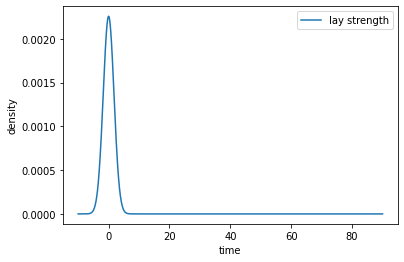

In [4]:
print(np.max(lay_d), np.sum(lay_d))
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
plt.plot(t, lay_d, label="lay strength")
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

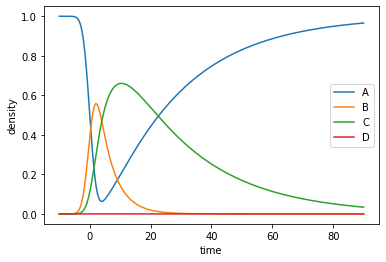

In [5]:
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
for state in state_numbers:
    plt.plot(t, dp[state_numbers[state]], label=state)
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

In [6]:
#　各過渡状態が持つ吸光度を導入し、すべての状態のミックスの吸光度の時間変化を計算する
absorbance_dic = {
    "A":None,
    "B":None,
    "C":None,
    "D":None,
}
def gaussian_arr_creator(mean, std, max_density=1, ramda_lst=[i for i in range(0, 1000)]):
    ramda_arr = np.array(ramda_lst)
    return ramda_arr, max_density*np.exp(-(ramda_arr - mean)**2/std**2)

ramda_arr, A_arr = gaussian_arr_creator(mean=350, std=10, max_density=0.2)
ramda_arr, B_arr = gaussian_arr_creator(mean=700, std=10, max_density=1.0)
ramda_arr, C_arr = gaussian_arr_creator(mean=600, std=10, max_density=0.5)
ramda_arr, D_arr = gaussian_arr_creator(mean=400, std=10, max_density=0.2)
absorbance_dic["A"] = A_arr
absorbance_dic["B"] = B_arr
absorbance_dic["C"] = C_arr
absorbance_dic["D"] = D_arr

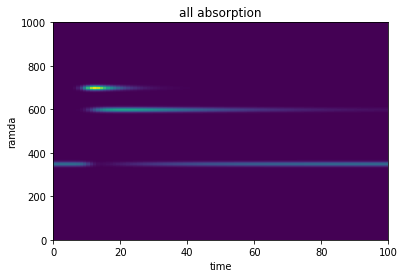

In [7]:
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range

abs_sum_arr = None
for name in state_numbers:
    if name in absorbance_dic:
        t_grid, ramda_grid = np.meshgrid(t[::len(t)//100], ramda_arr)
        abs_arr = np.outer(absorbance_dic[name], dp[state_numbers[name]][::len(t)//100])

        plt.pcolor(abs_arr)
        plt.xlabel("time")
        plt.ylabel("ramda")
        plt.title(name)
        if abs_sum_arr is None:
            abs_sum_arr = abs_arr
        else:
            abs_sum_arr += abs_arr


        plt.savefig("absorption"+name+".png")

plt.pcolor(abs_sum_arr)
plt.xlabel("time")
plt.ylabel("ramda")
plt.title("all absorption")
i += 1


plt.savefig("all absorption.png")